# Initial Experiments with Neural Fingerprint Embeddings

This notebook contains experiments varying the complexity of graphs upon which the neural fingerprint embedding is applied. Our hypothesis rests on the notion that NF embeddings perform well on smaller graphs with clearly distinguishable features but fail on complicated (or more generally, random) graphs. 

* Experiment 1: 500 Identical Cycle Graphs compared to 500 Identical Barabasi-Albert Graphs
* Experiment 2: 500 Different Erdos-Renyi Graphs compared to 500 Different Barabasi-Albert Graphs
* Experiment 3: 500 Identical Cycle Graphs compared to 500 Different Barabasi-Albert Graphs
* Experiment 4: 500 Identical Erdos-Renyi Graphs compared to 500 Identical Barabasi-Albert Graphs

In [2]:
import os, sys
import networkx as nx

sys.path.append("/afs/cs.stanford.edu/u/manans/graph-embeddings/embed/")
from embed import embed

%matplotlib inline

import matplotlib
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import NullFormatter
from sklearn import manifold, datasets
from time import time

from tqdm import tqdm

train_dir = '/dfs/scratch0/manans/nf-exp/train'
train_labels = {}
test_dir  = '/dfs/scratch0/manans/nf-exp/test'
emb_dir   = '/dfs/scratch0/manans/nf-exp/emb'

def save_graph(G, name, directory):
    nx.write_edgelist(G, directory + "/" + name)
    
def clean():
    os.system("rm " + train_dir + "/*")
    os.system("rm " + test_dir  + "/*")
    os.system("rm " + emb_dir   + "/*")
    
def plot_embedding(X, y, title=None):
    x_min, x_max = np.min(X, 0), np.max(X, 0)
    X = (X - x_min) / (x_max - x_min)

    fig = plt.figure()
    for i in range(X.shape[0]):
        if y[i] == 0:
            clr = 'b'
        elif y[i] == 1:
            clr = 'r'
        point = plt.plot(X[i, 0], X[i, 1], color=clr, marker='o')

    plt.xticks([]), plt.yticks([])
    if title is not None:
        plt.title(title)

# Experiment 1: 500 Identical Circle, 500 Identical Barabasi-Albert

In [4]:
circle_graphs = []
G = nx.cycle_graph(50)
for i in tqdm(xrange(500)):
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
G = nx.barabasi_albert_graph(50, 5, 0)
for i in tqdm(xrange(500)):
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:14<00:00, 34.44it/s]


In [5]:
e1_fingerprint_embeddings = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 5,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.500028698156
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 5
Iteration 0 loss 3.68668922424 train RMSE 0.959964302306 Validation RMSE 0 : 0.958634600414 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 3.06915335068 train RMSE 0.87587970648 Validation RMSE 1 : 0.875079893183 
	 Learning rate is constant => 0.000123409804087
Iteration 2 loss 2.52326487792 train RMSE 0.794171802874 Validation RMSE 2 : 0.79391688205 
	 L

100%|██████████| 200/200 [00:19<00:00, 46.28it/s]


Train: 0.573387051337
Test:  0.57482607034
--------------------------------------------------------------------------------


In [6]:
X = np.array([])
y = []

for i, key in enumerate(e1_fingerprint_embeddings.keys()):
    if i == 0:
        X = np.hstack((X, e1_fingerprint_embeddings[key]))
    else:
        X = np.vstack((X, e1_fingerprint_embeddings[key]))
    y.append(0 if int(key) < 500 else 1)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 199 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Iteration 25: error = 1.5472971, gradient norm = 0.0350592
[t-SNE] Iteration 50: error = 1.3807564, gradient norm = 0.0028147
[t-SNE] Iteration 75: error = 1.2135838, gradient norm = 0.0017416
[t-SNE] Iteration 100: error = 1.1626402, gradient norm = 0.0016078
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.162640
[t-SNE] Iteration 125: error = 1.0597007, gradient norm = 0.0013540
[t-SNE] Iteration 150: error = 1.0243561, gradient norm = 0.0012473
[t-SNE] Iteration 175: error = 1.0156729, gradient norm = 0.0012153
[t-SNE] Iteration 200: error = 1.0132995, gradient norm = 0.0012071
[t-SNE] Iteration 225: error = 1.0127022, gradient norm = 0.0012049
[t-SNE] Iteration 250: error = 1.0124930, gradient norm = 0.0012042
[t-SNE] Iteration 275: error = 1.0124412, gradient norm

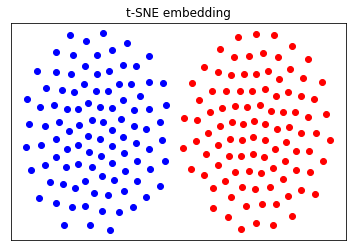

In [7]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=200, n_iter=3000, verbose=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, y, "t-SNE embedding")

# Experiment 2: 500 Different Erdos-Renyi, 500 Different Barabasi-Albert

100%|██████████| 500/500 [00:14<00:00, 33.59it/s]
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:126: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  b = plt.ishold()
/usr/local/lib/python2.7/dist-packages/networkx/drawing/nx_pylab.py:138: MatplotlibDeprecationWarning: pyplot.hold is deprecated.
    Future behavior will be consistent with the long-time default:
    plot commands add elements without first clearing the
    Axes and/or Figure.
  plt.hold(b)
/afs/cs.stanford.edu/u/manans/.local/lib/python2.7/site-packages/matplotlib/__init__.py:917: UserWarning: axes.hold is deprecated. Please remove it from your matplotlibrc and/or style files.
  warnings.warn(self.msg_depr_set % key)
/afs/cs.stanford.edu/u/manans/.local/lib/python2.7/site-packages/matplotlib/rcsetup.py:152: UserWarning: axes.hold is deprecate

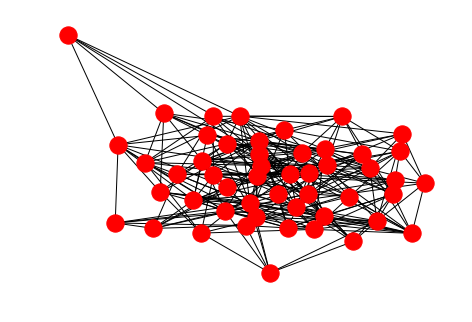

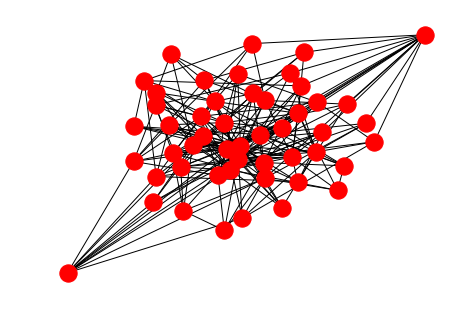

In [8]:
er_graphs = []
for i in tqdm(xrange(500)):
    G = nx.erdos_renyi_graph(50, 0.2)
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    er_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

In [10]:
e2_fingerprint_embeddings = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 10,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.500028698156
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 10
Iteration 0 loss 11.8666852126 train RMSE 1.72229373257 Validation RMSE 0 : 1.68213931753 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 10.1448633368 train RMSE 1.59244770435 Validation RMSE 1 : 1.55550432905 
	 Learning rate is constant => 0.000123409804087
Iteration 2 loss 8.57130911474 train RMSE 1.46374394584 Validation RMSE 2 : 1.43004224655 
	 Lear

100%|██████████| 200/200 [00:30<00:00,  6.64it/s]


Train: 0.575175885369
Test:  0.569651428417
--------------------------------------------------------------------------------


In [11]:
X = np.array([])
y = []

for i, key in enumerate(e2_fingerprint_embeddings.keys()):
    if i == 0:
        X = np.hstack((X, e2_fingerprint_embeddings[key]))
    else:
        X = np.vstack((X, e2_fingerprint_embeddings[key]))
    y.append(0 if int(key) < 500 else 1)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 199 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Iteration 25: error = 0.9303609, gradient norm = 0.0310852
[t-SNE] Iteration 50: error = 1.0136242, gradient norm = 0.0430009
[t-SNE] Iteration 75: error = 1.2085749, gradient norm = 0.0791715
[t-SNE] Iteration 100: error = 1.0447111, gradient norm = 0.0021934
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.044711
[t-SNE] Iteration 125: error = 0.9961219, gradient norm = 0.0007006
[t-SNE] Iteration 125: gradient norm 0.000701. Finished.
[t-SNE] Error after 125 iterations: 1.044711


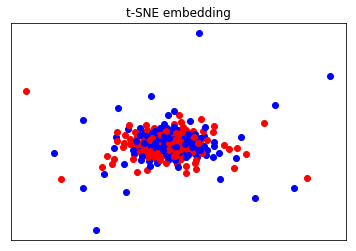

In [12]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=200, n_iter=3000, verbose=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, y, "t-SNE embedding")

# Experiment 3: 500 Identical Cycle Graphs, 500 Different BA Graphs

In [13]:
circle_graphs = []
G = nx.cycle_graph(50)
for i in tqdm(xrange(500)):
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    circle_graphs.append(G)
    
ba_graphs = []
for i in tqdm(xrange(500)):
    G = nx.barabasi_albert_graph(50, 5)
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:16<00:00, 27.14it/s]


In [14]:
e3_fingerprint_embeddings = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 5,
            train                   = True)

Loading data...
Regression on 560 training points.
--------------------------------------------------------------------------------
Mean predictor

Performance (RMSE) on label:
Train: 0.499971300197
Test:  0.500028698156
--------------------------------------------------------------------------------
Task params {'learn_rate': 0.00012340980408667956, 'fp_depth': 3, 'b1': 0.018315638888734179, 'b2': 0.018315638888734179, 'init_scale': 0.018315638888734179, 'fp_length': 50, 'l2_penalty': 0.018315638888734179, 'l1_penalty': 0.006737946999085467, 'conv_width': 10}
Total number of weights in the network: 11701
N_ITER 5
Iteration 0 loss 3.68668922424 train RMSE 0.959964302306 Validation RMSE 0 : 0.958634600414 
	 Learning rate is constant => 0.000123409804087
Iteration 1 loss 3.06915335068 train RMSE 0.87587970648 Validation RMSE 1 : 0.875079893183 
	 Learning rate is constant => 0.000123409804087
Iteration 2 loss 2.52326487792 train RMSE 0.794171802874 Validation RMSE 2 : 0.79391688205 
	 L

100%|██████████| 200/200 [00:19<00:00, 10.03it/s]


Train: 0.573387051337
Test:  0.57482607034
--------------------------------------------------------------------------------


In [15]:
X = np.array([])
y = []

for i, key in enumerate(e3_fingerprint_embeddings.keys()):
    if i == 0:
        X = np.hstack((X, e3_fingerprint_embeddings[key]))
    else:
        X = np.vstack((X, e3_fingerprint_embeddings[key]))
    y.append(0 if int(key) < 500 else 1)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 199 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Iteration 25: error = 1.5472971, gradient norm = 0.0350592
[t-SNE] Iteration 50: error = 1.3807564, gradient norm = 0.0028147
[t-SNE] Iteration 75: error = 1.2135838, gradient norm = 0.0017416
[t-SNE] Iteration 100: error = 1.1626402, gradient norm = 0.0016078
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.162640
[t-SNE] Iteration 125: error = 1.0597007, gradient norm = 0.0013540
[t-SNE] Iteration 150: error = 1.0243561, gradient norm = 0.0012473
[t-SNE] Iteration 175: error = 1.0156729, gradient norm = 0.0012153
[t-SNE] Iteration 200: error = 1.0132995, gradient norm = 0.0012071
[t-SNE] Iteration 225: error = 1.0127022, gradient norm = 0.0012049
[t-SNE] Iteration 250: error = 1.0124930, gradient norm = 0.0012042
[t-SNE] Iteration 275: error = 1.0124412, gradient norm

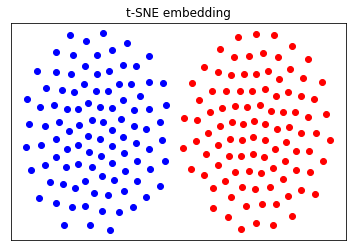

In [16]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=200, n_iter=3000, verbose=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, y, "t-SNE embedding")

# Experiment 4: 500 Identical ER Graphs, 500 Identical BA Graphs

In [17]:
er_graphs = []
G = nx.erdos_renyi_graph(50, 0.2)
for i in tqdm(xrange(500)):
    save_graph(G, str(i) + '.edgelist', train_dir if i < 400 else test_dir)
    if i < 400:
        train_labels[str(i) + '.edgelist'] = 0
    er_graphs.append(G)
    
ba_graphs = []
G = nx.barabasi_albert_graph(50, 5)
for i in tqdm(xrange(500)):
    save_graph(G, str(i + 500) + '.edgelist', train_dir if (i + 500) < 900 else test_dir)
    if (i + 500) < 900:
        train_labels[str(i + 500) + '.edgelist'] = 1
    ba_graphs.append(G)

100%|██████████| 500/500 [00:14<00:00, 31.22it/s]


In [ ]:
e4_fingerprint_embeddings = \
    embed(train_input_directory     = train_dir,
            train_label_mapping     = train_labels,
            test_input_directory    = test_dir,
            test_output_directory   = emb_dir,
            method                  = 'nf-original',
            n_epochs                = 30,
            train                   = True)

In [22]:
X = np.array([])
y = []

for i, key in enumerate(e4_fingerprint_embeddings.keys()):
    if i == 0:
        X = np.hstack((X, e4_fingerprint_embeddings[key]))
    else:
        X = np.vstack((X, e4_fingerprint_embeddings[key]))
    y.append(0 if int(key) < 500 else 1)

[t-SNE] Computing pairwise distances...
[t-SNE] Computing 199 nearest neighbors...
[t-SNE] Computed conditional probabilities for sample 200 / 200
[t-SNE] Mean sigma: 1125899906842624.000000
[t-SNE] Iteration 25: error = 0.2591864, gradient norm = 0.0189299
[t-SNE] Iteration 50: error = 0.5016629, gradient norm = 0.0138568
[t-SNE] Iteration 75: error = 0.3750146, gradient norm = 0.0232791
[t-SNE] Iteration 100: error = 1.0737977, gradient norm = 0.0482273
[t-SNE] KL divergence after 100 iterations with early exaggeration: 1.073798
[t-SNE] Iteration 125: error = 1.0744240, gradient norm = 0.0216369
[t-SNE] Iteration 150: error = 0.9241610, gradient norm = 0.0008613
[t-SNE] Iteration 150: gradient norm 0.000861. Finished.
[t-SNE] Error after 150 iterations: 1.073798


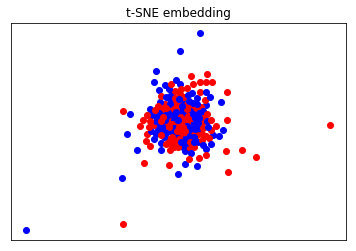

In [23]:
tsne = manifold.TSNE(n_components=2, init='pca', random_state=0, perplexity=200, n_iter=3000, verbose=2)
X_tsne = tsne.fit_transform(X)
plot_embedding(X_tsne, y, "t-SNE embedding")